In [1]:
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/codebasics/nlp-tutorials/main/14_word_vectors_spacy_text_classification/news_dataset.json")

In [2]:
df.head()

,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [3]:
df.isnull().any()

text        False
category    False
dtype: bool

In [4]:
df.category.value_counts()

CRIME       2500
SPORTS      2500
BUSINESS    2500
Name: category, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['labels'] = encoder.fit_transform(df['category'])

In [6]:
df.head()

,text,category,labels
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,1
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,1
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,2
3,This Richard Sherman Interception Literally Sh...,SPORTS,2
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,0


In [7]:
import spacy
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")
nlp = spacy.load("en_core_web_lg")


In [8]:
def preprocessing(text):
    doc = nlp(text)
    
    result = []
    
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        result.append(token.lemma_)
        
    return wv.get_mean_vector(result)

In [9]:
df['vectors'] = df.text.apply(lambda x: preprocessing(x))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.vectors, df.labels, test_size=0.2)

In [11]:
X_train.shape, X_test.shape

((6000,), (1500,))

In [12]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

X_train_2d.shape, X_test_2d.shape

((6000, 300), (1500, 300))

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_xtrain = scaler.fit_transform(X_train_2d)
scaled_xtest = scaler.fit_transform(X_test_2d)

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

model = MultinomialNB()
model.fit(scaled_xtrain, y_train)
prediction = model.predict(scaled_xtest)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       535
           1       0.88      0.89      0.88       478
           2       0.82      0.87      0.84       487

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [15]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train_2d, y_train)
prediction = model.predict(X_test_2d)

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       535
           1       0.87      0.89      0.88       478
           2       0.88      0.87      0.87       487

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



Text(51.0, 0.5, 'Truth')

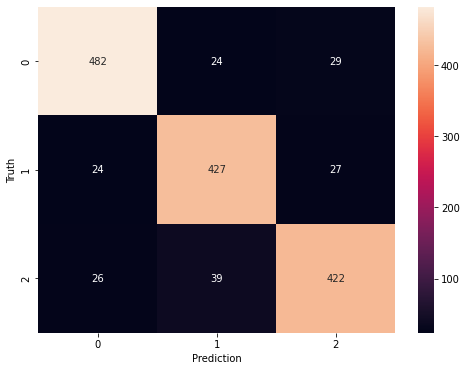

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)

plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction")
plt.ylabel("Truth")